# Implementation of Value Iteration Algorithm

The algorithm works by first applying Value Iteration on an MDP to find the optimal value function. Then, the optimal policy is found by applying Policy Extraction Algorithm on the optimal values.

### Imports

In [1]:
import jax
import jax.numpy as jnp

from mdp import MDP
from mdp import visualize_policy_and_values

### Define a MDP

In [2]:
# create the MDP
mdp = MDP.create()

# initialize random keys for policy and value generation
key = jax.random.PRNGKey(0)
key, v_key, p_key = jax.random.split(key, 3)

# hyperparameters for RL algorithm
gamma = 0.9 # discount factor
theta=1e-5 # convergence threshold for policy evaluation

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


The mdp contains : 

- states S
- actions A
- transition probabilities P(s'|s,a)
- rewards R(s', a, s)

In [3]:
mdp.infos()

MDP infos:
S: [0 1 2 3 4 5 6 7 8]
A: [0 1 2 3]
P(s'|s,a).shape: (9, 4, 9)
R(s', a, s).shape: (9, 4, 9)


### Implement Value Iteration

Value Iteration enables computing the optimal values for a given MDP.

In [4]:
@jax.jit
def value_iteration(values, theta):
    """Compute the optimal value function given a MDP

    :param values: initial values
    :param theta: convergence threshold
    """
    def body_fn(values_delta):
        values, delta = values_delta
        # set new values and delta to zero
        new_values = jnp.zeros((values.shape))
        delta = 0
        # iterate over all states
        for s in mdp.states:
            values_array = jnp.zeros((mdp.actions.shape))
            # iterate over all the actions to see which one gives the maximum value
            for a in mdp.actions:
                p_transition = mdp.transition_probabilities[s, a]
                rewards = mdp.rewards[s, a]
                # to do the sum of intermediate expected returns for all s' given this pair of s, a
                value = jnp.sum(p_transition * (rewards + gamma * values))
                # update the values array for this action
                values_array = values_array.at[a].set(value)
            # set the updated value as the max of the value array (best action)
            updated_value = jnp.max(values_array)
            # update delta
            delta = jnp.maximum(delta, jnp.abs(updated_value - values[s]))
            # update new values for the current state
            new_values = new_values.at[s].set(updated_value)
        return (new_values, delta)
        
    def cond_fn(vals_delta):
        # return delta > theta because we want to continue the loop if it is the case (no convergence yet)
        values, delta = vals_delta
        return delta > theta
    
    # set intial delta to inf so we ensure the 1st cond fn is True
    initial_vals_delta = (values, jnp.inf)
    # use jax.while loop with the condition and body functions defined above (while cond is True, do body ...)
    vals_delta = jax.lax.while_loop(cond_fn, body_fn, initial_vals_delta)
    values, _ = vals_delta
    return values

#### Define a random Value function and a random Policy and visualize them

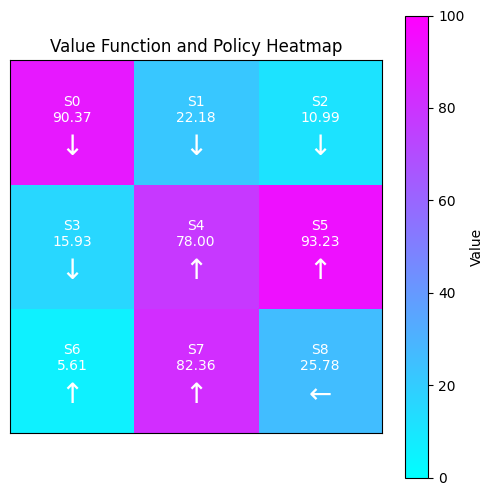

In [5]:
key = jax.random.PRNGKey(42)
key, v_key, p_key = jax.random.split(key, 3)

values = jax.random.uniform(v_key, shape=(mdp.states.shape), minval=0, maxval=100)
policy = jax.random.randint(p_key, shape=(mdp.states.shape), minval=jnp.min(mdp.actions), maxval=jnp.max(mdp.actions))
visualize_policy_and_values(policy, values)

#### Apply Value Iteration and visualize the updated Values

We compute the optiaml values for this MDP, but our policy is still random.

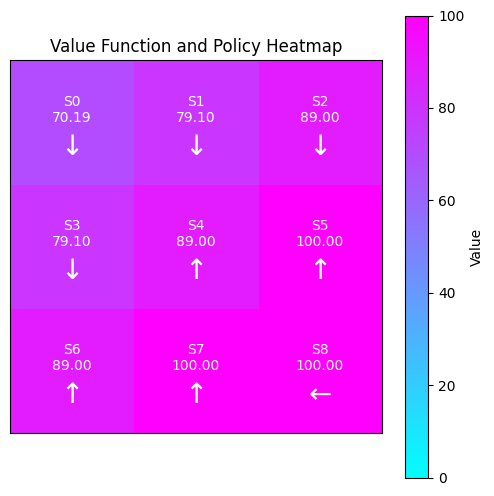

In [6]:
values = value_iteration(values, theta=1e-5)
visualize_policy_and_values(policy, values)

#### Define and apply Policy Extraction

Given the optimal values, we compute the optimal policy for each state

In [7]:
def value_extraction(policy, values):
    """Compute optimal policy given optimal values for a MPD

    :param policy: initial policy
    :param values: optimal values
    :return: optimal policy
    """
    # initialize new policy
    new_policy = jnp.zeros((policy.shape), dtype=int)
    # iterate over all states
    for s in mdp.states:
        # evaluate each action to choose the best
        evals = jnp.zeros((mdp.actions.shape))
        for a in mdp.actions:
            p_transition = mdp.transition_probabilities[s, a]
            rewards = mdp.rewards[s, a]
            # sum the expected returns for all s' given s and a
            eval = jnp.sum(p_transition * (rewards + gamma * values))
            evals = evals.at[a].set(eval)
        # update the new policy with the action yielding the highest expected return
        best_action = jnp.argmax(evals)
        new_policy = new_policy.at[s].set(best_action)

    return new_policy

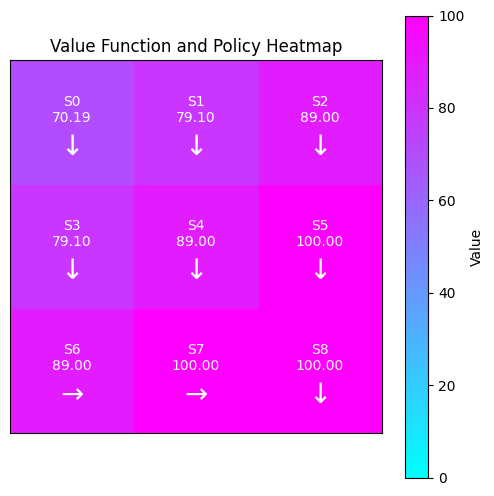

In [8]:
optimal_policy = value_extraction(policy, values)
visualize_policy_and_values(optimal_policy, values)